# A probabilistic nearest neighbour method for statistical pattern recognition

## Overview and theoretical part

KNN algorithm is one the canonical methods for data analysis and statistical pattern recognition. It's mostly used in classifications problems where we were given with labelled test dataset and then want to predict for which class belongs our new data(point). 

Its workflow is pretty easy and based on searching **K** nearest neighbours of a new point(piece of data), checking their classes and returning the most common class among them. 

But there is a **problem**. We do not know which **K** we should choose. There were a lot of researches which tried to approximate it somehow, but still it's a problem to choose **K**.

So, this method uses different approach and does't require a **K** value at all as well as any other user-set parameters.  

The main idea is to "guess" this **K** parameter(and *beta* also) by trying to converge two chains with parameters: 
   1. *K* starts from 1, *beta* starts from 10
   2. *K* starts from K_MAX, *beta* starts from 0.01
   
At each iteration we generate new k and beta depending on the last elements in the chain by doing something like:

$$ \hat{k} = k \pm U[0, 1, 2, 3] $$
$$ \hat{\beta} = \beta + N[0, v] $$

Then checking the **J** acceptance rate, which tells us with what probability we have to accept these new values and add them to the chain.

$$ J = \min \{1, \frac{p(Y|X, \hat{\beta}, \hat{k})}{p(Y|X, \beta, k)}\} $$

And in the end, when we have enough big chains(paper recommends 1000 elements) we can check if their *mean* and *variance* indistinguishable. If yes, then accept these parameters as appropriate for our model and data. 

## Practical measurements and comparisons

### Data preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

Index(['xs', 'ys', 'yc'], dtype='object')
(250, 2)


<IPython.core.display.Javascript object>


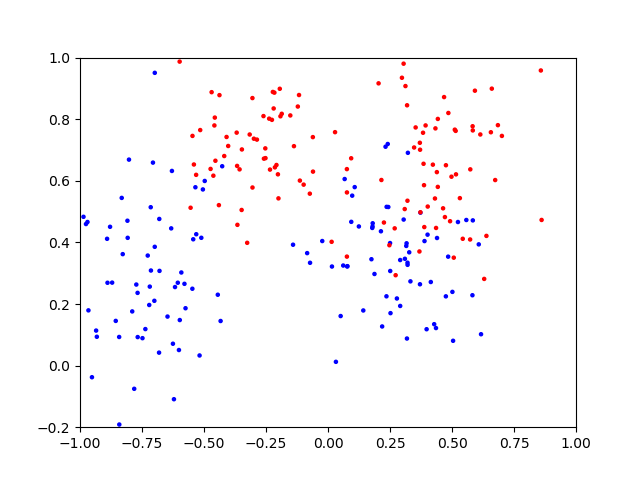

In [4]:
df = pd.read_csv("./dataset/synth/train.csv")
print(df.columns)

xTrain = np.array(df[["xs", "ys"]])
print(xTrain.shape)
yTrain = np.array(df["yc"])

plt.figure()
plt.xlim((-1, 1))
plt.ylim((-0.2, 1))
plt.scatter(xTrain[:,0], xTrain[:,1], c=yTrain, s=5, cmap="bwr")

### Trying sklearn implementation of KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(xTrain, yTrain)

x = np.linspace(-1, 1, num=50, endpoint=True)
y = np.linspace(-0.2, 1, num=50, endpoint=True)
X, Y = np.meshgrid(x, y)
Z = model.predict_proba(np.c_[X.ravel(), Y.ravel()])[:,0]
Z_knn = Z.reshape(X.shape)

plt.figure(figsize=(11,9))
plt.xlim((-1, 1))
plt.ylim((-0.2, 1))
plt.scatter(xTrain[:,0], xTrain[:,1], c=yTrain, s=5, cmap="bwr")
CS = plt.contour(X, Y, Z_knn)
plt.clabel(CS, inline=1, fontsize=10)

### Our implementation of PNN Classifier

You can find an implementation of this class in **PNNClassifier.py** file.

A brief description of some of its methods:
  1. fit(X, Y) : fitting data and finding those **k** and **beta** parameters.
  2. predict_proba(X) : predicts a probability of belonging to each class for each point in **X** array
  3. pygivenYXBetaK(y, beta, K): returns the most probable class for yn+1 is given by the most common class found among its k nearest neighbours.
  $$ p(y_{n+1}|x_{n+1}, Y, X, \beta, k) = \frac{\exp\{\beta(1/k) \sum \delta_{y_{n+1} y_j} \}}{ \sum_{q=1}^{Q} \exp\{\beta(1/k) \sum \delta_{q y_j} } $$ 
  4. _rearrangeRelativeToEachPoint and _rearrangeData : functions which rearranges(sorts) data relative some(specific) or for each point

In [12]:
from PNNClassifier import PNNClassifier

In [14]:
pnn_model = PNNClassifier()
pnn_model.fit(xTrain, yTrain)

In [18]:
Z = pnn_model.predict_proba(np.c_[X.ravel(), Y.ravel()])[:,0]
Z_pnn = Z.reshape(X.shape)

<a list of 6 text.Text objects>

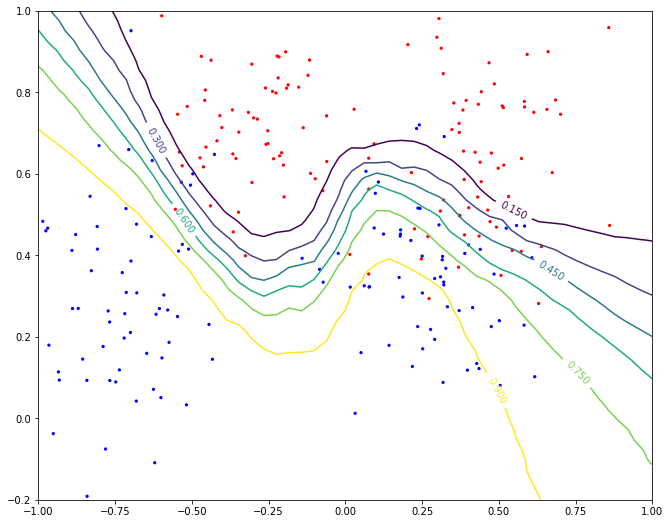

In [21]:
plt.figure(figsize=(11,9))
plt.xlim((-1, 1))
plt.ylim((-0.2, 1))
plt.scatter(xTrain[:,0], xTrain[:,1], c=yTrain, s=5, cmap="bwr")
CS = plt.contour(X, Y, Z_pnn)
plt.clabel(CS, inline=1, fontsize=10)

### Compare our PNN method with the Ripley's

The **sklearn** library uses another method at its KNN implementation. It's called *Ripley method*(the five-nearestneighbours method).

The same comparison was given in the paper.

<a list of 2 text.Text objects>

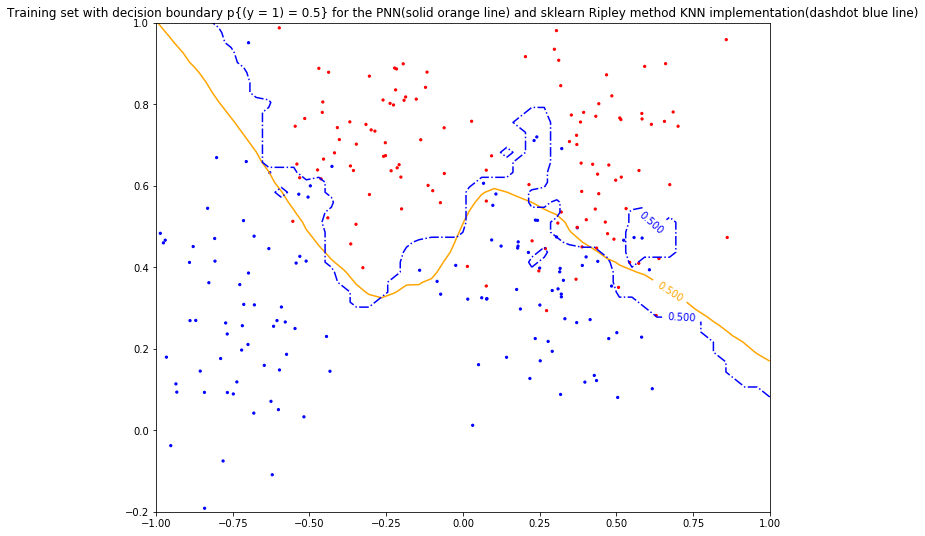

In [33]:
plt.figure(figsize=(11,9))
plt.title('Training set with decision boundary p{(y = 1) = 0.5} for the PNN(solid orange line) and sklearn Ripley method KNN implementation(dashdot blue line)')
plt.xlim((-1, 1))
plt.ylim((-0.2, 1))
plt.scatter(xTrain[:,0], xTrain[:,1], c=yTrain, s=5, cmap="bwr")
CS = plt.contour(X, Y, Z_pnn, levels=[0.5], colors="orange")
plt.clabel(CS, inline=1, fontsize=10, colors="orange")
CS = plt.contour(X, Y, Z_knnn, levels=[0.5], colors="blue", linestyles="dashdot")
plt.clabel(CS, inline=1, fontsize=10, colors="blue")

## Results

So, we implemented the PNN classifier which does not require any *user-set* parameter at all and performs pretty well(as you can see in charts above). We have repeated PNN paper and got the same results. (just compare our chart above and chart in the paper on the 5th page, they are the same). 
If at the start of all workflow we had little understanding of how it should working, then by the end we understood all the probability and math behind it. 

At first, we tried to do everything in "brute-force" way and calculate the integral as it's described, but it was too slow and we implemented their improvement which boosted everything by ~10times. So, in the end, after all our improvements we got *fitting* in ~55sec instead of ~1hour in the start. 